<a href="https://colab.research.google.com/github/NMashalov/2023_OpenMipt_course/blob/main/lesson12/CI_lin_models_stud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Семинар

$\newcommand{\indep}{\perp \!\!\! \perp}$
$\newcommand{\notindep}{\not\!\perp \!\!\! \perp}$

In [7]:
import pandas as pd
import numpy as np
import scipy.stats as sps

from matplotlib import pyplot as plt
from matplotlib import style
import seaborn as sns

from tqdm.notebook import tqdm

import statsmodels.api as sm
import statsmodels.datasets as smd
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

import warnings
warnings.filterwarnings("ignore")

sns.set(style='whitegrid', font_scale=1.3, palette='Set2')

## Учет различных признаков в линейной регрессии для оценки ATE

На основе материалов <a href="https://matheusfacure.github.io/python-causality-handbook/landing-page.html">учебника</a>.

### 0. Инициализация и обучение моделей через формулы
В этом семинаре нам понадобится модуль `statsmodels.formula.api`, который позволяет задавать модели, указав формулу в виде `target ~ features`, которая означает линейную функцию `target` от `features`.

Рассмотрим пример задания модели линейной регрессии OLS (подробнее можно почитать в [документации](https://www.statsmodels.org/dev/example_formulas.html)).


In [ ]:
df = sm.datasets.get_rdataset("Guerry", "HistData").data
df = df[['Lottery', 'Literacy', 'Wealth', 'Region']].dropna()
df.head()

,Lottery,Literacy,Wealth,Region
0,41,37,73,E
1,38,51,22,N
2,66,13,61,C
3,80,46,76,E
4,79,69,83,E


Итак, предположим, нам нужно обучить модель для таргета `Lottery` по признакам `Literacy`, `Wealth` и `Region` из датасета выше. Тогда синтаксис будет выглядеть таким образом:

In [ ]:
model = smf.ols(formula='Lottery ~ Literacy + Wealth + Region', data=df)
res = model.fit()

Метод `fit` возвращает объект типа `statsmodels.regression.linear_model.RegressionResults`, который содержит различные характеристики модели:
* в первой секции представлены различные характеристики самой модели
  * параметры обучения,
  * $R^2$
  * Проверка гипотезы о значимости регрессии в целом
  * логарифмическая функция правдоподобия
  * информационные критерии
* во второй секции &mdash; подробная информация о коэффициентов, включая анализ их стат. значимости:
  * названия коэффициентов (совпадают с именами признаков, или `Intercept` для свободного коэффициента);
  * оценки коэффициентов;
  * стандартные ошибки &mdash; корень из оценки дисперсии оценки каждого из коэффициентов;
  * t-статистика для проверки гипотезы о незначимости коэффициента;
  * p-value критерия для проверки гипотезы о незначимости коэффициента (правило: если $\text{p-value} \leqslant \alpha=0.05$, то гипотеза отвергается, иначе &mdash; не отвергается);
  * левая и правая граница 95\% доверительного интервала для коэффициента.
* в третьей секции &mdash; анализ остатков модели
  * критерии проверки несмещенности, нормальности

*Подробнее:* https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.html

Посмотрим на результат **в предположении гомоскедастичности**

In [ ]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                Lottery   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     6.636
Date:                Mon, 01 Jan 2024   Prob (F-statistic):           1.07e-05
Time:                        18:16:42   Log-Likelihood:                -375.30
No. Observations:                  85   AIC:                             764.6
Df Residuals:                      78   BIC:                             781.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      38.6517      9.456      4.087      

Заметим, что модель автоматически добавила свободный член (`Intercept`) и рассмотрела признак `Region` как категориальный, затем удалив одну из категорий (`С`). Так произошло, потому что значения были строками. При этом, если бы мы имели целочисленный призак и хотели бы рассмотреть его как категориальный, то заключили бы его в `C()` при передаче в формулу. То есть, чтобы специфически указать, что признак категориальный:


In [ ]:
model = smf.ols(formula='Lottery ~ Literacy + Wealth + C(Region)', data=df)
res = model.fit()
print(res.params)

Intercept         38.651655
C(Region)[T.E]   -15.427785
C(Region)[T.N]   -10.016961
C(Region)[T.S]    -4.548257
C(Region)[T.W]   -10.091276
Literacy          -0.185819
Wealth             0.451475
dtype: float64


### 1. Использование признаков: хороший случай

**Задача:** исследовать влияние отправки email с напоминанием о долге. Таргет &mdash; сумма платежей от клиентов, которые просрочили платеж.

Выбраны 5000 случайных клиентов для проведения *рандомизированного эксперимента*. Каждый клиент получает электронное письмо случайно с вероятностью 0.5.

Загрузим данные collections_email.csv из [репозитория](https://github.com/matheusfacure/python-causality-handbook/blob/master/causal-inference-for-the-brave-and-true/data/collections_email.csv)

In [ ]:
!wget https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/master/causal-inference-for-the-brave-and-true/data/collections_email.csv

--2024-01-01 18:17:56--  https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/master/causal-inference-for-the-brave-and-true/data/collections_email.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 258042 (252K) [text/plain]
Saving to: ‘collections_email.csv’

collections_email.c 100%[===================>] 251.99K  --.-KB/s    in 0.03s   

2024-01-01 18:17:56 (7.91 MB/s) - ‘collections_email.csv’ saved [258042/258042]



In [ ]:
DATA_PATH = "collections_email.csv"

In [ ]:
data = pd.read_csv(DATA_PATH)
data.head()

,payments,email,opened,agreement,credit_limit,risk_score
0,740,1,1.0,0.0,2348.495260,0.666752
1,580,1,1.0,1.0,334.111969,0.207395
2,600,1,1.0,1.0,1360.660722,0.550479
3,770,0,0.0,0.0,1531.828576,0.560488
4,660,0,0.0,0.0,979.855647,0.455140


Поскольку данные рандомизированы, простая разность средних оценивает ATE.
Иначе говоря, ничто не может быть причиной тритмента, кроме рандомизации, поэтому потенциальные исходы не зависят от лечения:  $C_0, C_1 \indep T$

In [ ]:
data.query("email==1")["payments"].mean() - data.query("email==0")["payments"].mean()

-0.6202804021329484

Проведите АВ-тесты, чтобы оценить различие между группами (`email`) по таргету (`payments`), двумя способами: с помощью модели OLS и с помощью `ttest_ind`. Сравните результаты и сделайте выводы.

In [ ]:
sps.ttest_ind(data.query("email==1")["payments"],data.query("email==0")["payments"])

TtestResult(statistic=-0.21087238565395539, pvalue=0.8329954493440059, df=4998.0)

По t-test отвергаем гипотезу

In [ ]:
model = smf.ols(formula='payments ~ email', data=data).fit()
print(model.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    669.9764      2.061    325.116      0.000     665.937     674.016
email         -0.6203      2.941     -0.211      0.833      -6.387       5.146


**Вывод:**
Результат t-test и линейной модели идентичны. Призрнак email статзначимо не разделяет таргет

Что делать? Вернуться к заказчику, поджав хвост, и сказать, что эксперимент безрезультатен и нужно больше данных?

Но посмотрим на другие признаки

* `credit_limit` &mdash; кредитный лимит клиента до того, как он просрочил платеж;
* `risk_score` &mdash; предполагаемый риск для клиента до момента отправки email.


Добавьте их в качестве признаков и обучите модель


In [ ]:
model_2 = smf.ols(formula='payments ~ email+ credit_limit + risk_score ', data=data).fit()
print(model_2.summary().tables[1])

                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      490.8653      9.715     50.527      0.000     471.820     509.911
email            4.4304      2.130      2.080      0.038       0.255       8.606
credit_limit     0.1511      0.008     18.833      0.000       0.135       0.167
risk_score      -8.0516     38.424     -0.210      0.834     -83.379      67.276


Заметим, что можно извлечь результаты отдельных тестов, например, проверку гипотезы о незначимости коэффициента перед признаком `email`

In [ ]:
result = model_2.t_test('email = 0')
result

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             4.4304      2.130      2.080      0.038       0.255       8.606

Рассмотренные признаки могут объяснить разброс значений таргета, снизив тем самым его дисперсию. Кроме того, они не влияют на принадлежность к группе, тем самым не могут внести смещение.

Итог: **любые признаки, которые влияют на таргет, не влияя при этом на тритмент, можно использовать в модели**. Они называются **ковариатами**. Это помогает снизить дисперсию.

### 2. Использование признаков: нежелательный случай

Загрузим данные hospital_treatment.csv из [репозитория](https://github.com/matheusfacure/python-causality-handbook/blob/master/causal-inference-for-the-brave-and-true/data/hospital_treatment.csv).

Две больницы проводят рандомизированное испытание нового препарата для лечения некоторой болезни. Таргет &mdash; количество дней госпитализации, хотим сократить эту величину. В одной больнице его назначают 90% пациентам, соответственно 10% пациентов получают плацебо. В другой больнице дают препарат случайным 10% своих пациентам, соответственно 90% получают плацебо. Причем известно, что первая больница обычно получает более тяжелые случаи заболевания.

In [4]:
!wget https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/master/causal-inference-for-the-brave-and-true/data/hospital_treatment.csv

--2024-01-04 11:24:30--  https://raw.githubusercontent.com/matheusfacure/python-causality-handbook/master/causal-inference-for-the-brave-and-true/data/hospital_treatment.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2068 (2.0K) [text/plain]
Saving to: ‘hospital_treatment.csv.1’

hospital_treatment. 100%[===================>]   2.02K  --.-KB/s    in 0s      

2024-01-04 11:24:30 (48.2 MB/s) - ‘hospital_treatment.csv.1’ saved [2068/2068]



In [10]:
DATA_PATH = "hospital_treatment.csv"

In [13]:
df = pd.read_csv(DATA_PATH)
df.head()

,hospital,treatment,severity,days
0,1,1,29.686618,82
1,1,1,20.050340,57
2,1,1,20.302399,49
3,0,0,10.603118,44
4,0,0,8.332793,15


Так как исследование не рандомизированное, то по общим данным смотреть нельзя

In [16]:
hosp_1 = smf.ols(formula='days ~ treatment', data=df).fit()
#print(model_2.summary().tables[1])
hosp_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,33.2667,2.662,12.498,0.000,27.968,38.566
treatment,14.1533,3.367,4.204,0.000,7.451,20.856


Но можно посмотреть отдельно по каждой больнице (`hospital`)

In [17]:
hosp_2 = smf.ols(formula='days ~ treatment', data=df.query('hospital==0')).fit()
hosp_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,30.4074,2.868,10.602,0.000,24.523,36.292
treatment,-11.4074,10.921,-1.045,0.306,-33.816,11.001


In [20]:
hosp_3 = smf.ols(formula='days ~ treatment', data=df.query('hospital==1')).fit()
hosp_3.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,59.0000,6.747,8.745,0.000,45.442,72.558
treatment,-10.3958,6.955,-1.495,0.141,-24.371,3.580


Поскольку мы рассматриваем каждую больницу отдельно, данных недостаточно, и результаты не являются стат. значимыми.

Но мы знаем, что на результат влияет степень тяжести заболевания, и можем включить ее в модель. Такой признак называется **конфаундером (confounder)**, он влечет как тритмент, так и таргет.

In [25]:
hosp_4 = smf.ols(formula='days ~ treatment + severity', data=df.query('hospital==0')).fit()
hosp_4.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,8.4304,2.897,2.910,0.007,2.475,14.386
treatment,-7.5741,5.599,-1.353,0.188,-19.083,3.935
severity,2.7329,0.311,8.795,0.000,2.094,3.372


Нужно ли включить больницу в модель? Мы же знаем, что лечение назначается в больницах, и, кажется это будет дополнительной информацией.

Однако, при фиксировании степени тяжести и тритмента, больница не коррелирует таргетом. Она влечет только тритмент, поэтому не является конфаундером. Для снижения дисперсии, этот признак должен быть хорошей ковариатой таргета, а не тритмента.

Если мы попробуем его использовать, мы повысим дисперсию

In [26]:
hosp_5 = smf.ols(formula='days ~ treatment + severity', data=df.query('hospital==1')).fit()
hosp_5.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,10.1625,7.068,1.438,0.157,-4.049,24.374
treatment,-3.8305,4.455,-0.860,0.394,-12.788,5.127
severity,2.1590,0.249,8.658,0.000,1.658,2.660


**Выводы:**

Итог:
* Необходимо добавлять в модель **переменные-ковариаты**, которые влекут таргет.
* Необходимо добавлять в модель **переменные-конфаундеры**, которые влекут как тритмент, так и таргет.
* Не следует добавлять в модель переменные, которые могут только спрогнозировать тритмент.

### 3. Использование признаков: плохой случай, возникновение смещения

Вернемся к примеру с письмами. Рассмотрим два дополнительных признака, которые есть в наших данных:
* `opened` &mdash; открыл ли клиент письмо или нет,
* `agreement` &mdash; клиент связался для обсуждения своего долга после получения письма.

Какая из следующих моделей лучше? Только с `email + credit_limit + risk_score` или с еще двумя признаками?

In [ ]:
email_1 = <...>
email_1.summary().tables[1]

In [ ]:
email_2 = <...>
email_2.summary().tables[1]

Первая модель находит статистически значимые результаты для коэффициента `email`, вторая &mdash; нет. Кажется, раз первая модель смогла найти разницу, то она круче. Но ведь во второй модели мы учли дополнительные факторы, и, может быть, она на самом деле правильная, и тритмент никак не влияет на результат?

---

К какому из трех типов признаков относятся `opened` и `agreement`?

**Ответ:**

*Примечание.* Заметим, что `email` может влиять на таргет не только через opened, но и напрямую. Например, клиент увидел письмо, и погасил свой долг, не открывая само письмо.

Проблема заключается в том, что теперь помимо основного пути `email -> payment` у нас еще есть дополнительный путь `email -> opened -> agreement -> payment`. Тем самым часть истинного эффекта влияния тритмента на таргет перетекла на дополнительный путь, который не учтен в коэффициенте линейной регрессии перед `email`. Ведь есть еще и `opened=1`, то вклад в эффект является уже суммой двух коэффициентов линейной регрессии.

### 4. Замечание: Bad COP

Пусть есть следующий признак

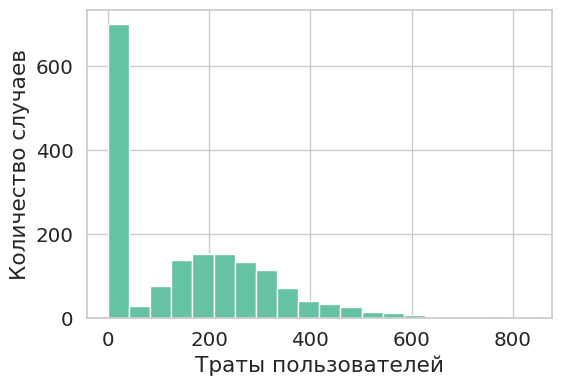

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(np.concatenate([
    np.random.gamma(5, 50, 1000),
    np.zeros(700)
]),  bins = 20)
plt.xlabel("Траты пользователей")
plt.ylabel("Количество случаев")
plt.show()

Кажется, что можно произвести моделирование в 2 этапа:
* Первая часть &mdash; предсказание, потратит ли клиент деньги.
* Вторая часть &mdash; предсказание того, сколько конкретно клиент потратит денег, если он вообще потратит.

Вторая часть называется *эффектом обусловленности положительными результатами* (**Conditional-on-Positives effect, COP**). В нашем случае это то, сколько тратит клиент после того, как он решил потратиться.

Они соеденены следующим утверждением

$$\mathsf{E}(Y|T) = \mathsf{E}(Y|Y>0, T)\ \mathsf{P}(Y>0|T).$$


Проблема в том, что вторая часть COP является предвзятой даже при рандомизированном эксперименте. Например, по следующим соображениям.
* Некоторые потратившиеся потратились только потому что на них оказал воздействие тритмент. Если бы его не было, они бы не стали тратиться.
* Но некоторые тратятся всегда независимо от тритмента. Точнее, тритмент может побудить их тратить больше, но и без него они тратятся.

Ключевой момент &mdash; эти два типа клиентов несопоставимы. Для первых потенциальных исход $C_0=0$, для вторых $C_0>0$. При удалении нулей мы тем самым уберем из контрольной выборки тех клиентов, которые при воздействии тритмента перестали бы быть нулями.

Посмотрим на проблему с математической точки зрения. При случайном назначении тритмента эффект равен разнице средних

$$\begin{split}
\begin{align*}
&\mathsf{E}(Y|T=1) - \mathsf{E}(Y|T=0)\\
&=\mathsf{E}(Y|Y>0, T=1)\mathsf{P}(Y>0|T=1) - \mathsf{E}(Y|Y>0, T=0)\mathsf{P}(Y>0|T=0)\\
&=\underbrace{\bigg[\mathsf{P}(Y>0|T=1) - \mathsf{P}(Y>0|T=0)\bigg]}_{Participation \ Effect} \cdot \mathsf{E}(Y|Y>0, T=1)\\
&+\underbrace{\bigg[\mathsf{E}(Y|Y>0, T=1) - \mathsf{E}(Y|Y>0, T=0)\bigg]}_{COP \ Effect} \cdot \mathsf{P}(Y>0|T=0).
\end{align*}
\end{split}$$

То есть разница средних состоит из двух частей:
* разность вероятностей того, что таргет является положительным между группами, это называется *эффектом участия*,
* разность таргетов между группами среди потратившихся, *эффект COP*.

Пока все хорошо, это математическое тождество. Проблема возникает, когда мы пытаемся оценить каждую часть по отдельности. Посмотрим внимательнее на эффект COP.
$$
\mathsf{E}(Y|Y>0, T=1) - \mathsf{E}(Y|Y>0, T=0)=\\=\mathsf{E}(С_{1}|С_{1}>0)-\mathsf{E}(С_{0}|С_{0}>0) \\
=\underbrace{\mathsf{E}(С_{1} - С_{0}|С_{1}>0)}_{Causal \ Effect} + \underbrace{\bigg[ \mathsf{E}(С_{0}|С_{1}>0) - \mathsf{E}(С_{0}|С_{0}>0) \bigg]}_{Selection \ Bias}.
$$

Здесь мы получаем
* причинно-следственный эффект для тех, кто решил что-то потратить.
* смещение между теми, кто решил принять участие, когда назначен тритмент и теми, которые участвуют даже без тритмента.

При оценке COP-составляющей мы исключаем тех клиентов, которые потратились бы при воздействии тритмента, но им не был назначен тритмент. Иначе говоря, мы исключаем $\{С_{0}=0,С_{1}>0, T=0\}$, тем самым неправильно оценивая группу $C_0=0$, внося несопоставимость между клиентам, уменьшая тем самым правильное смещение.


**Итог: нельзя контролировать признаки, которые либо находятся между тритментом и таргетом, либо являются общим эффектом тритмента и таргета.**

## Статистические свойства линейной регрессии

Загрузим датасет с данными по стоимости квартир в Москве (<a href="https://raw.githubusercontent.com/bdemeshev/em301/master/datasets/flats_moscow.txt">источник</a>).

In [ ]:
!wget https://raw.githubusercontent.com/bdemeshev/em301/master/datasets/flats_moscow.txt

--2024-01-01 18:37:40--  https://raw.githubusercontent.com/bdemeshev/em301/master/datasets/flats_moscow.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64916 (63K) [text/plain]
Saving to: ‘flats_moscow.txt’

flats_moscow.txt    100%[===================>]  63.39K  --.-KB/s    in 0.01s   

2024-01-01 18:37:40 (5.39 MB/s) - ‘flats_moscow.txt’ saved [64916/64916]



In [ ]:
flats = pd.read_csv("flats_moscow.txt", sep='\t')
flats.head()

,n,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
0,1,81,58,40,6.0,12.5,7,1,1,1,3
1,2,75,44,28,6.0,13.5,7,1,0,1,6
2,3,128,70,42,6.0,14.5,3,1,1,1,3
3,4,95,61,37,6.0,13.5,7,1,0,1,1
4,5,330,104,60,11.0,10.5,7,0,1,1,3


Будем рассматривать зависимость цены квартиры от ее площади.

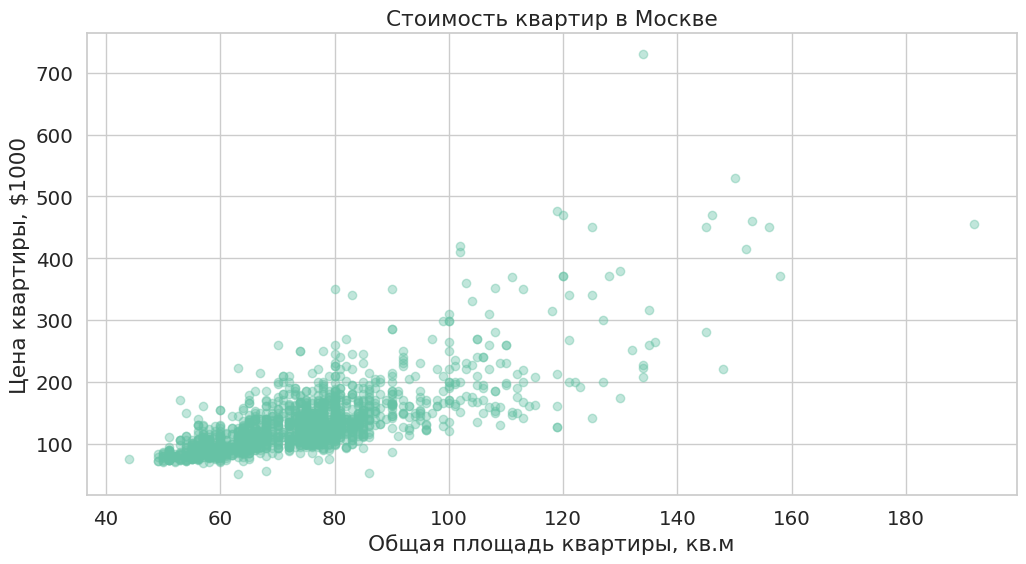

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(flats['totsp'], flats['price'], alpha=0.4)
plt.title('Стоимость квартир в Москве')
plt.xlabel('Общая площадь квартиры, кв.м')
plt.ylabel('Цена квартиры, $1000');

По графику явно видна гетероскедастичность.

*Примечание. Строго говоря, такой проверки недостаточно, стоит проверять зависимость остатков, а не таргета. Если хотя бы по одному признаку видна разная дисперсия остатков, то имеет смысл говорить о гетероскедастичности.*

### 1. Обучение простой линейной модели

Сначала обучим линейную регрессию предсказания стоимости квартиры по ее площади.

Посмотрим на результаты модели, полученные **в предположении гомоскедастичности**.

Можно извлечь результаты отдельных тестов, например, проверка гипотезы о незначимости коэффициента перед признаком `totsp`.

Посмотрим на ковариационную матрицу вектора $\widehat{\theta}$ **в условиях гомоскедастичности**, что в данном случае не выполнено. Её можно получить с помощью метода `cov_params`.

У нас явная гетероскедастичность, проверим это критериями.

### 2. Проверка на гетероскедастичность

*При наличии подозрений на гетероскедастичность рекомендуется сразу использовать устойчивые оценки дисперсии (см. далее), не применяя проверку на гетероскедастичность стат. критериями. Данные критерии также имеют свои ошибки, и последовательное применение нескольких критериев может суммировать вероятности ошибок.*

$\mathsf{H}_0: \gamma_2 = \gamma_3 = ... = \gamma_p ⇔ σ_1^2 = ... = σ_n^2 \Leftrightarrow \,{\large остатки \,\, гомоскедатичны}$

$\mathsf{H}_1: \mathsf{H}_0 \,\,{\large неверна}$

**Критерий Бройша-Пагана**

In [ ]:
test = sms.het_breuschpagan(<...>, <...>)

name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
pd.Series(test, index=name)

**Критерий Голдфелда-Квандта**

In [ ]:
test = sms.het_goldfeldquandt(<...>, <...>)

name = ["F statistic", "p-value", "type"]
pd.Series(test, index=name)

**Критерий Уайта**

In [ ]:
test = sms.het_white(<...>, <...>)

name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
pd.Series(test, index=name)

### 3. Использование устойчивых оценок дисперсии

Получите оценку ковариационной матрицы вектора $\widehat{\theta}$ в условиях гетероскедастичности. Возьмите `cov_type="HC3"` у метода `fit` модели и посмотрите на результат. Интерпретация значений в таблицах аналогична, см. пояснения выше.

**Вопрос:** Что изменилось при использовании поправки на гетероскедатичность?

**Ответ:**



Посмотрим матрицу ковариации, к сожалению, названия параметров теряются, поэтому необходимо добавить подписи столбцов и строк вручную.

In [ ]:
pd.DataFrame(
    <...>,
    index=<...>,
    columns=<...>
)

### 4. Пример с несколькими признаками

Рассмотрим регрессионную модель $$price = \theta_0 + \theta_1 \cdot totsp + \theta_2 \cdot livesp + \theta_3 \cdot dist$$

Напишите формулу для модели и укажите тип используемой оценки матрицы ковариаций в предположении гетероскедастичности.

In [ ]:
model2 = smf.ols(<...>, flats)
results2 = model2.fit(cov_type=<...>)
print(results2.summary())

Как и раньше, можно извлечь результаты отдельных тестов.

In [ ]:
results2.t_test('totsp = 0')

С помощью t-критерия можно проверять одну любую линейную гипотезу. Например, гипотеза о равенстве $\theta_{totsp} = 2\theta_{dist}$.

In [ ]:
results2.t_test('totsp = 2*dist')

Можно использовать  f-критерий для проверки нескольких линейных гипотез.

Например, проверим гипотезу об одновременной незначимости коэффициентов перед признаками `livesp`, `dist`.

In [ ]:
print(results2.f_test("(livesp=0), (dist=0)"))

Можно проверить гипотезу о равенстве $\theta_{totsp} = \theta_{dist}$.

In [ ]:
print(results2.f_test("(livesp=dist)"))

**Выводы:**